In [336]:
# coding: utf-8
%matplotlib inline


import os as os
from IPython import embed

from datetime import datetime
import glob
import math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from scipy.stats import gmean
import statsmodels.api as sm
import subprocess
import unicodedata

# import statsmodels.formula.api as smf  # <- NB fails with some index names (Pygments issue)



sns.set(style='whitegrid')

def get_filenames(import_path, wildcard='*.csv', filt=()):
    names = glob.glob(os.path.join(import_path, wildcard))
    if filt:
        names = [name for name in names if any(f in name for f in filt)]
    
    return names

In [337]:
files = get_filenames('../raw_data/',)
files

['../raw_data/20170223_000000_agent_statistics.csv',
 '../raw_data/20170223_000000_group_statistics.csv',
 '../raw_data/20170224_000000_agent_statistics.csv',
 '../raw_data/20170224_000000_group_statistics.csv',
 '../raw_data/20170227_000000_agent_statistics.csv',
 '../raw_data/20170227_000000_group_statistics.csv',
 '../raw_data/20170228_000000_agent_statistics.csv',
 '../raw_data/20170228_000000_group_statistics.csv',
 '../raw_data/20170301_000000_agent_statistics.csv',
 '../raw_data/20170301_000000_group_statistics.csv',
 '../raw_data/20170303_000000_agent_statistics.csv',
 '../raw_data/20170303_000000_group_statistics.csv',
 '../raw_data/20170306_000000_agent_statistics.csv',
 '../raw_data/20170306_000000_group_statistics.csv',
 '../raw_data/20170307_000000_agent_statistics.csv',
 '../raw_data/20170308_000000_agent_statistics.csv',
 '../raw_data/20170308_000000_group_statistics.csv',
 '../raw_data/20170309_000000_agent_statistics.csv',
 '../raw_data/20170309_000000_group_statistics

In [338]:
agent_files = get_filenames('../raw_data/', filt=('agent',))
group_files = get_filenames('../raw_data/', filt=('group',))

In [475]:
def read_data(path):
    df = pd.read_csv(path, index_col=0)
    
    # remove whitespace and '.' from column names to allow easier referencing later
    df.rename(columns=lambda x: x.strip().replace('.', ''), inplace=True)  
    
    # store filename in 'filename' column in case needed later
    try:
        df['filename'] = path.split('/')[-1:][0]
    except:
        df['filename'] = path
    
    return df


def add_date_index_if_not_exists(df):
    if not 'timestamp' in df.index.name:
        filename_date = df['filename'].map(lambda x: x.split('_')[0])
        df['date'] = pd.to_datetime(filename_date)
        df.set_index(['date'], inplace=True, drop=True, append=True)
        df = df.reorder_levels(['date', 'agent name'])
    
    return df


def parse_time_to_timedelta(df):
    for col in df.columns:
        if re.search(r'time$', col, re.I):
            try:
                df[col] = df[col].map(lambda x: pd.to_timedelta(x))
            except:
                raise TypeError('cannot parse "{}" to time'.format(col))
    
    return df


def concat_data(filepaths):
    frames = []
    
    for filepath in filepaths:
        df = read_data(filepath)
        df = df.dropna()
        df = add_date_index_if_not_exists(df)
        df = parse_time_to_timedelta(df)
        frames.append(df)  # append dataframe to list
        
    data = pd.concat(frames)  # concatenate dataframes in frames
    data.columns.name = 'param'
    
    return data

agent_data = concat_data(agent_files)
print(agent_data.shape)
agent_data.head(10)

(272, 6)


param                      num calls handled  num calls unanswered  \
date       agent name                                                
2017-02-23 Reception L1                   49                    50   
           Back Office3                   64                    62   
           Reception Desk                 52                    45   
           Back Office1                    4                     3   
2017-02-24 Reception L1                   78                    57   
           Back Office3                   63                    46   
           Reception Desk                 65                    35   
           Back Office1                   15                     1   
2017-02-27 Reception L1                   69                    26   
           Back Office3                   99                    91   

param                     avg call time total talk time total staffed time  \
date       agent name                                                        
2017-02-23 Reception L1        00:02:11        01:30:45             1 days   
           Back Office3        00:01:43        01:32:51             1 days   
           Reception Desk      00:01:53        01:25:32             1 days   
           Back Office1        00:06:13        00:22:45             1 days   
2017-02-24 Reception L1        00:02:21        01:58:45             1 days   
           Back Office3        00:02:03        01:34:30             1 days   
           Reception Desk      00:02:27        01:52:06             1 days   
           Back Office1        00:04:32        00:58:19             1 days   
2017-02-27 Reception L1        00:04:41        03:05:19             1 days   
           Back Office3        00:02:13        03:08:12             1 days   

param                                                  filename  
date       agent name                                            
2017-02-23 Reception L1    20170223_000000_agent_statistics.csv  
           Back Office3    20170223_000000_agent_statistics.csv  
           Reception Desk  20170223_000000_agent_statistics.csv  
           Back Office1    20170223_000000_agent_statistics.csv  
2017-02-24 Reception L1    20170224_000000_agent_statistics.csv  
           Back Office3    20170224_000000_agent_statistics.csv  
           Reception Desk  20170224_000000_agent_statistics.csv  
           Back Office1    20170224_000000_agent_statistics.csv  
2017-02-27 Reception L1    20170227_000000_agent_statistics.csv  
           Back Office3    20170227_000000_agent_statistics.csv

In [368]:
agent_data['avg call time'].head()

date        agent name    
2017-02-23  Reception L1     00:02:11
            Back Office3     00:01:43
            Reception Desk   00:01:53
            Back Office1     00:06:13
2017-02-24  Reception L1     00:02:21
Name: avg call time, dtype: timedelta64[ns]

In [369]:
agent_data_clean = data.dropna()
agent_data_clean = agent_data_clean.drop('filename', axis=1)
agent_data_clean = data_clean.T
agent_data_clean.head(10)

param                     num calls handled num calls unanswered  \
date       agent name                                              
2017-02-23 Reception L1                  49                   50   
           Back Office3                  64                   62   
           Reception Desk                52                   45   
           Back Office1                   4                    3   
2017-02-24 Reception L1                  78                   57   
           Back Office3                  63                   46   
           Reception Desk                65                   35   
           Back Office1                  15                    1   
2017-02-27 Reception L1                  69                   26   
           Back Office3                  99                   91   

param                        avg call time  total talk time total staffed time  
date       agent name                                                           
2017-02-23 Reception L1    0 days 00:02:11  0 days 01:30:45    1 days 00:00:00  
           Back Office3    0 days 00:01:43  0 days 01:32:51    1 days 00:00:00  
           Reception Desk  0 days 00:01:53  0 days 01:25:32    1 days 00:00:00  
           Back Office1    0 days 00:06:13  0 days 00:22:45    1 days 00:00:00  
2017-02-24 Reception L1    0 days 00:02:21  0 days 01:58:45    1 days 00:00:00  
           Back Office3    0 days 00:02:03  0 days 01:34:30    1 days 00:00:00  
           Reception Desk  0 days 00:02:27  0 days 01:52:06    1 days 00:00:00  
           Back Office1    0 days 00:04:32  0 days 00:58:19    1 days 00:00:00  
2017-02-27 Reception L1    0 days 00:04:41  0 days 03:05:19    1 days 00:00:00  
           Back Office3    0 days 00:02:13  0 days 03:08:12    1 days 00:00:00

In [370]:
agent_data_by_date = data_clean.stack('date')
agent_data_by_date.head(10)

agent name                   Back Office1 Back Office3 Reception Desk  \
param             date                                                  
num calls handled 2017-02-23            4           64             52   
                  2017-02-24           15           63             65   
                  2017-02-27            0           99             85   
                  2017-02-28            0           47             25   
                  2017-03-01           60           58             49   
                  2017-03-03           15           66             48   
                  2017-03-06           66           63             79   
                  2017-03-07            6           60             75   
                  2017-03-08           25           73             27   
                  2017-03-09           11           42             38   

agent name                   Reception L1  
param             date                     
num calls handled 2017-02-23           49  
                  2017-02-24           78  
                  2017-02-27           69  
                  2017-02-28           28  
                  2017-03-01           97  
                  2017-03-03           72  
                  2017-03-06           86  
                  2017-03-07           71  
                  2017-03-08           72  
                  2017-03-09           63

In [371]:
agent_data_by_date['Total'] = agent_data_by_date.sum(axis=1)
agent_data_by_date.head(10)

agent name                   Back Office1 Back Office3 Reception Desk  \
param             date                                                  
num calls handled 2017-02-23            4           64             52   
                  2017-02-24           15           63             65   
                  2017-02-27            0           99             85   
                  2017-02-28            0           47             25   
                  2017-03-01           60           58             49   
                  2017-03-03           15           66             48   
                  2017-03-06           66           63             79   
                  2017-03-07            6           60             75   
                  2017-03-08           25           73             27   
                  2017-03-09           11           42             38   

agent name                   Reception L1 Total  
param             date                           
num calls handled 2017-02-23           49   169  
                  2017-02-24           78   221  
                  2017-02-27           69   253  
                  2017-02-28           28   100  
                  2017-03-01           97   264  
                  2017-03-03           72   201  
                  2017-03-06           86   294  
                  2017-03-07           71   212  
                  2017-03-08           72   197  
                  2017-03-09           63   154

In [372]:
agent_data_by_date.tail(10)

agent name                        Back Office1     Back Office3  \
param              date                                           
total staffed time 2017-05-23  1 days 00:00:00  1 days 00:00:00   
                   2017-05-24  1 days 00:00:00  1 days 00:00:00   
                   2017-05-25  1 days 00:00:00  1 days 00:00:00   
                   2017-05-26  1 days 00:00:00  1 days 00:00:00   
                   2017-05-30  1 days 00:00:00  1 days 00:00:00   
                   2017-05-31  1 days 00:00:00  1 days 00:00:00   
                   2017-06-01  1 days 00:00:00  1 days 00:00:00   
                   2017-06-05  1 days 00:00:00  1 days 00:00:00   
                   2017-06-06  1 days 00:00:00  1 days 00:00:00   
                   2017-06-08  1 days 00:00:00  1 days 00:00:00   

agent name                      Reception Desk     Reception L1  \
param              date                                           
total staffed time 2017-05-23  1 days 00:00:00  1 days 00:00:00   
                   2017-05-24  1 days 00:00:00  1 days 00:00:00   
                   2017-05-25  1 days 00:00:00  1 days 00:00:00   
                   2017-05-26  1 days 00:00:00  1 days 00:00:00   
                   2017-05-30  1 days 00:00:00  1 days 00:00:00   
                   2017-05-31  1 days 00:00:00  1 days 00:00:00   
                   2017-06-01  1 days 00:00:00  1 days 00:00:00   
                   2017-06-05  1 days 00:00:00  1 days 00:00:00   
                   2017-06-06  1 days 00:00:00  1 days 00:00:00   
                   2017-06-08  1 days 00:00:00  1 days 00:00:00   

agent name                               Total  
param              date                         
total staffed time 2017-05-23  4 days 00:00:00  
                   2017-05-24  4 days 00:00:00  
                   2017-05-25  4 days 00:00:00  
                   2017-05-26  4 days 00:00:00  
                   2017-05-30  4 days 00:00:00  
                   2017-05-31  4 days 00:00:00  
                   2017-06-01  4 days 00:00:00  
                   2017-06-05  4 days 00:00:00  
                   2017-06-06  4 days 00:00:00  
                   2017-06-08  4 days 00:00:00

In [373]:
agent_data_by_date.stack('agent name').unstack(['param', 'agent name'])

param      num calls handled                                                 \
agent name      Back Office1 Back Office3 Reception Desk Reception L1 Total   
date                                                                          
2017-02-23                 4           64             52           49   169   
2017-02-24                15           63             65           78   221   
2017-02-27                 0           99             85           69   253   
2017-02-28                 0           47             25           28   100   
2017-03-01                60           58             49           97   264   
2017-03-03                15           66             48           72   201   
2017-03-06                66           63             79           86   294   
2017-03-07                 6           60             75           71   212   
2017-03-08                25           73             27           72   197   
2017-03-09                11           42             38           63   154   
2017-03-10                 8           32             47           61   148   
2017-03-14                 3           90             40           54   187   
2017-03-15                37           39             37           65   178   
2017-03-16                 2           39             32           50   123   
2017-03-20                56           72             73           71   272   
2017-03-21                15           61             45           56   177   
2017-03-22                 0           68             47           56   171   
2017-03-23                15           45             59           77   196   
2017-03-24                 7           71             49           85   212   
2017-03-27                34           56             67           68   225   
2017-03-28                 2           67             54           58   181   
2017-03-29                23           50             53           67   193   
2017-03-30                 5           41             43           67   156   
2017-03-31                12           47             38           67   164   
2017-04-03                52           31             61           75   219   
2017-04-05                 8           31             14           19    72   
2017-04-06                 0           51             57           74   182   
2017-04-07                25           36             46           79   186   
2017-04-08                 0            0              0            0     0   
2017-04-11                23           46             45           67   181   
...                      ...          ...            ...          ...   ...   
2017-04-21                 0           28             52           73   153   
2017-04-22                 0            0              0            0     0   
2017-04-23                 0            0              0            0     0   
2017-04-24                26           68             86          100   280   
2017-04-25                20           44             18           30   112   
2017-04-26                 4           60             55           75   194   
2017-04-27                17           47             43           58   165   
2017-05-01                 0            0              0            0     0   
2017-05-02                27           75            100           97   299   
2017-05-03                27           65             69           54   215   
2017-05-05                 5           43             64           74   186   
2017-05-09                26           68             58           59   211   
2017-05-10                 8           53             26           28   115   
2017-05-11                16           58             59           92   225   
2017-05-12                10           54             44           82   190   
2017-05-15                26           54             71           90   241   
2017-05-16                 2           82         

In [474]:
group_data = concat_data(group_files)
print(group_data.shape)
group_data.head(10)

(6528, 10)


param,num busy overflows,num calls answered,num calls abandoned,num calls transferred,num calls timed out,avg num agents talking,avg num agents staffed,avg wait time,avg abandonment time,filename
timestamp,,,,,,,,,,
Feb 23 2017 12:00:00 AM,0,0,0,0,0,0.0,4.0,0 days,0 days,20170223_000000_group_statistics.csv
Feb 23 2017 12:15:00 AM,0,0,0,0,0,0.0,4.0,0 days,0 days,20170223_000000_group_statistics.csv
Feb 23 2017 12:30:00 AM,0,0,0,0,0,0.0,4.0,0 days,0 days,20170223_000000_group_statistics.csv
Feb 23 2017 12:45:00 AM,0,0,0,0,0,0.0,4.0,0 days,0 days,20170223_000000_group_statistics.csv
Feb 23 2017 1:00:00 AM,0,0,0,0,0,0.0,4.0,0 days,0 days,20170223_000000_group_statistics.csv
Feb 23 2017 1:15:00 AM,0,0,0,0,0,0.0,4.0,0 days,0 days,20170223_000000_group_statistics.csv
Feb 23 2017 1:30:00 AM,0,0,0,0,0,0.0,4.0,0 days,0 days,20170223_000000_group_statistics.csv
Feb 23 2017 1:45:00 AM,0,0,0,0,0,0.0,4.0,0 days,0 days,20170223_000000_group_statistics.csv
Feb 23 2017 2:00:00 AM,0,0,0,0,0,0.0,4.0,0 days,0 days,20170223_000000_group_statistics.csv


In [459]:
group_data.index

Index(['Feb 23  2017 12:00:00 AM', 'Feb 23  2017 12:15:00 AM',
       'Feb 23  2017 12:30:00 AM', 'Feb 23  2017 12:45:00 AM',
       'Feb 23  2017 1:00:00 AM', 'Feb 23  2017 1:15:00 AM',
       'Feb 23  2017 1:30:00 AM', 'Feb 23  2017 1:45:00 AM',
       'Feb 23  2017 2:00:00 AM', 'Feb 23  2017 2:15:00 AM',
       ...
       'Jun 8  2017 9:30:00 PM', 'Jun 8  2017 9:45:00 PM',
       'Jun 8  2017 10:00:00 PM', 'Jun 8  2017 10:15:00 PM',
       'Jun 8  2017 10:30:00 PM', 'Jun 8  2017 10:45:00 PM',
       'Jun 8  2017 11:00:00 PM', 'Jun 8  2017 11:15:00 PM',
       'Jun 8  2017 11:30:00 PM', 'Jun 8  2017 11:45:00 PM'],
      dtype='object', name='timestamp', length=6528)

In [443]:
group_data['avg wait time'].head()

timestamp
Feb 23  2017 12:00:00 AM   0 days
Feb 23  2017 12:15:00 AM   0 days
Feb 23  2017 12:30:00 AM   0 days
Feb 23  2017 12:45:00 AM   0 days
Feb 23  2017 1:00:00 AM    0 days
Name: avg wait time, dtype: timedelta64[ns]

In [472]:
group_split_datetime = group_data.copy()
group_split_datetime.drop('filename', axis=1, inplace=True)

def parse_date_time(x):
    dt = pd.to_datetime(x.name)
#     print(type(dt))
    return pd.Series([
            dt,
            dt.date(),
            dt.time()
        ])

group_split_datetime[['timestamp', 'date', 'time']] = group_split_datetime.apply(parse_date_time, axis=1)
group_split_datetime.set_index(['date', 'time'], drop=True, inplace=True, append=False)
group_split_datetime.index.get_level_values('time')
group_split_datetime

param                num busy overflows  num calls answered  \
date       time                                               
2017-02-23 00:00:00                   0                   0   
           00:15:00                   0                   0   
           00:30:00                   0                   0   
           00:45:00                   0                   0   
           01:00:00                   0                   0   
           01:15:00                   0                   0   
           01:30:00                   0                   0   
           01:45:00                   0                   0   
           02:00:00                   0                   0   
           02:15:00                   0                   0   
           02:30:00                   0                   0   
           02:45:00                   0                   0   
           03:00:00                   0                   0   
           03:15:00                   0                   0   
           03:30:00                   0                   0   
           03:45:00                   0                   0   
           04:00:00                   0                   0   
           04:15:00                   0                   0   
           04:30:00                   0                   0   
           04:45:00                   0                   0   
           05:00:00                   0                   0   
           05:15:00                   0                   0   
           05:30:00                   0                   0   
           05:45:00                   0                   0   
           06:00:00                   0                   0   
           06:15:00                   0                   0   
           06:30:00                   0                   0   
           06:45:00                   0                   0   
           07:00:00                   0                   0   
           07:15:00                   0                   0   
...                                 ...                 ...   
2017-06-08 16:30:00                   0                   5   
           16:45:00                   0                   7   
           17:00:00                   0                   0   
           17:15:00                   0                   5   
           17:30:00                   0                   3   
           17:45:00                   0                   0   
           18:00:00                   0                   1   
           18:15:00                   0                   1   
           18:30:00                   0                   0   
           18:45:00                   0                   0   
           19:00:00                   0                   0   
           19:15:00                   0                   0   
           19:30:00                   0                   0   
           19:45:00                   0                   0   
           20:00:00                   0                   0   
           20:15:00                   0                   0   
           20:30:00                   0                   0   
           20:45:00                   0                   0   
           21:00:00                   0                   0   
           21:15:00                   0                   0   
           21:30:00                   0                   0   
           21:45:00                   0                   0   
           22:00:00                   0                   0   
           22:15:00                   0                   0   
           22:30:00                   0                   0   
           22:45:00                   0                   0   
           23:00:00                   0                   0   
           23:15:00                   0                   0   
           23:30:00                   0                   0   
           23:45:00                   0                   0   

param                num calls

In [453]:
group_split_datetime.index.get_level_values('time')

Index(['12:00:00 AM', '12:15:00 AM', '12:30:00 AM', '12:45:00 AM',
       '1:00:00 AM', '1:15:00 AM', '1:30:00 AM', '1:45:00 AM', '2:00:00 AM',
       '2:15:00 AM',
       ...
       '9:30:00 PM', '9:45:00 PM', '10:00:00 PM', '10:15:00 PM', '10:30:00 PM',
       '10:45:00 PM', '11:00:00 PM', '11:15:00 PM', '11:30:00 PM',
       '11:45:00 PM'],
      dtype='object', name='time', length=6528)

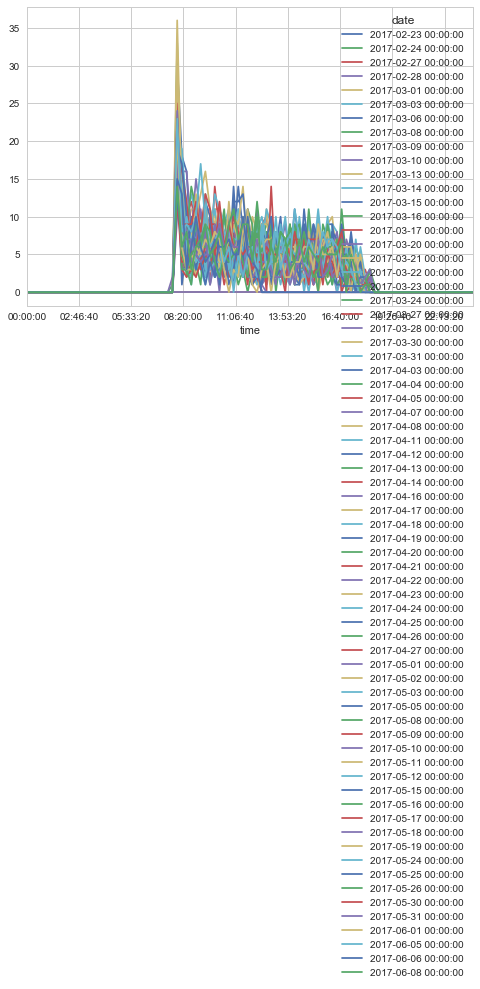

In [473]:
group_split_datetime.unstack('date')['num calls answered'].plot()

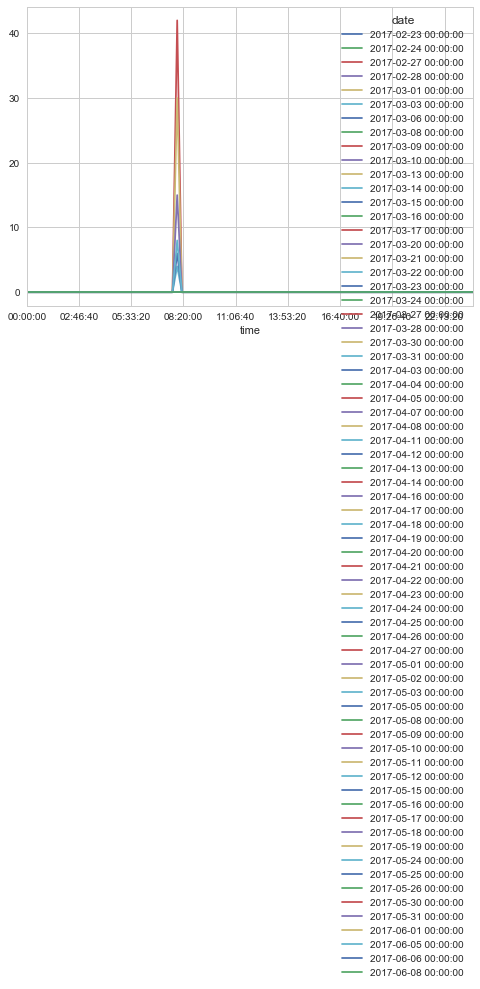

In [476]:
group_split_datetime.unstack('date')['num busy overflows'].plot()

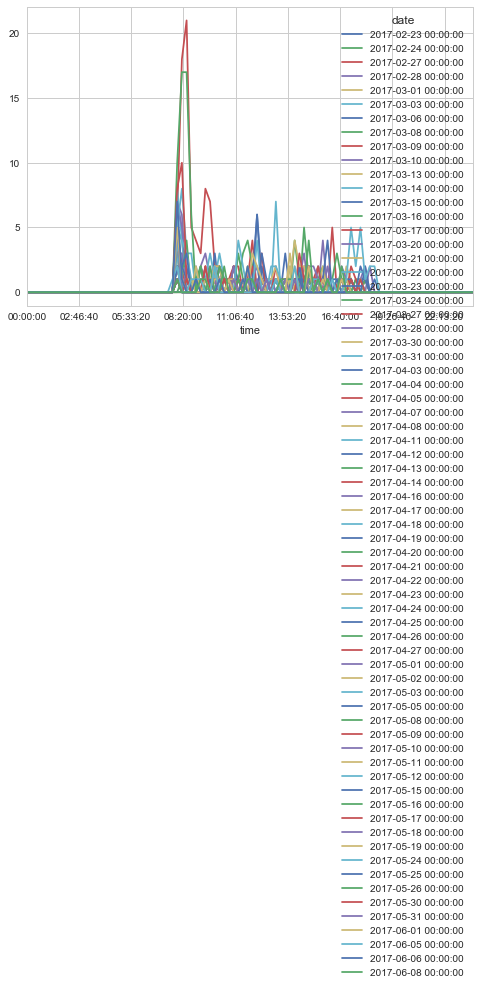

In [477]:
group_split_datetime.unstack('date')['num calls abandoned'].plot()

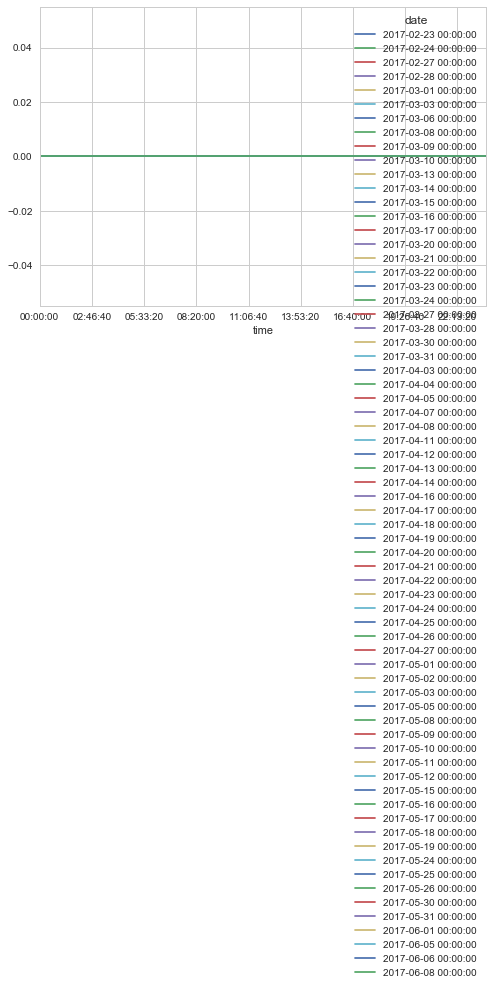

In [478]:
group_split_datetime.unstack('date')['num calls transferred'].plot()

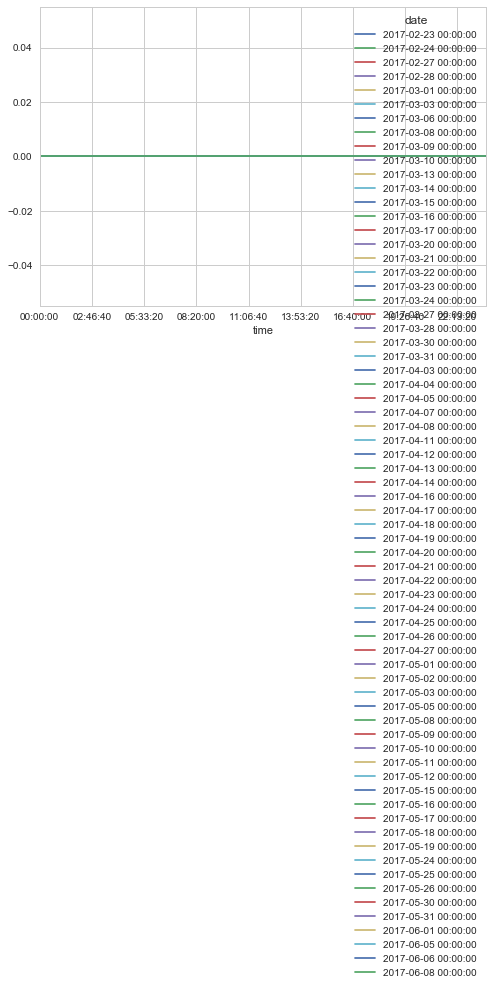

In [479]:
group_split_datetime.unstack('date')['num calls timed out'].plot()

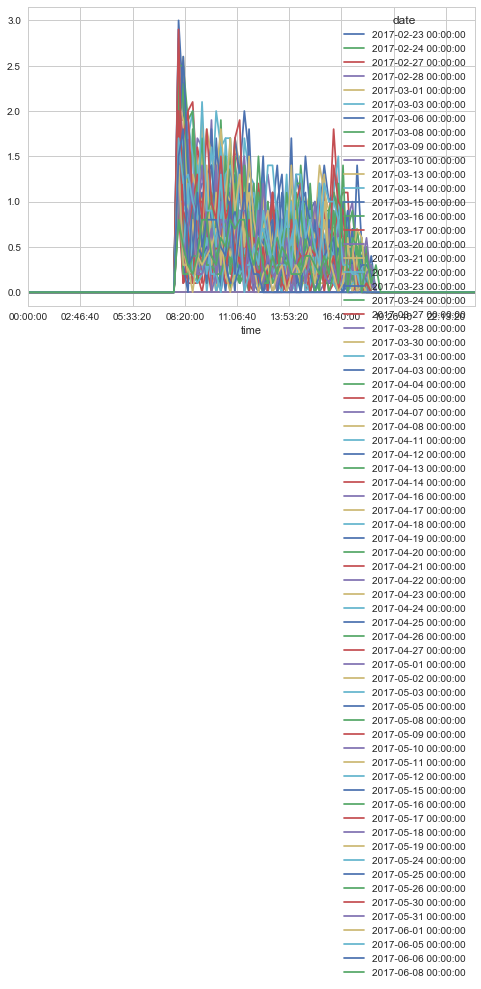

In [480]:
group_split_datetime.unstack('date')['avg num agents talking'].plot()

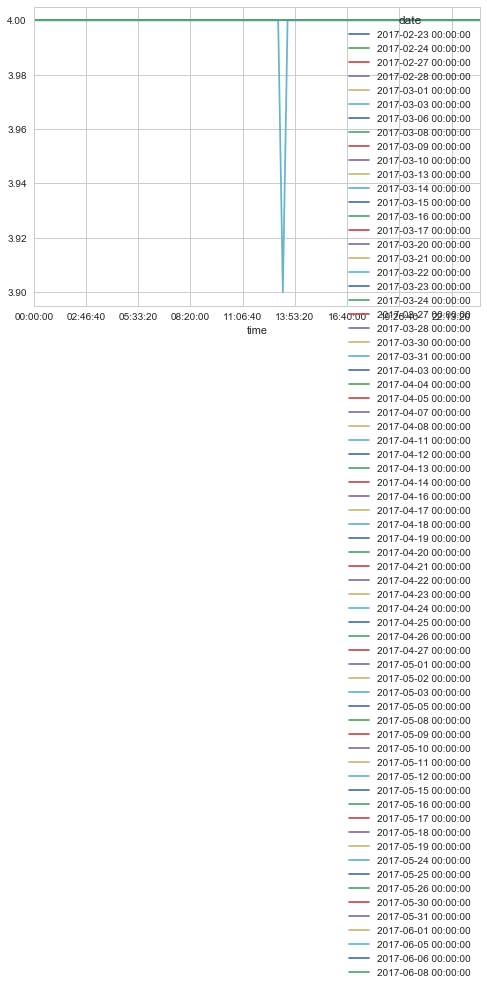

In [481]:
group_split_datetime.unstack('date')['avg num agents staffed'].plot()

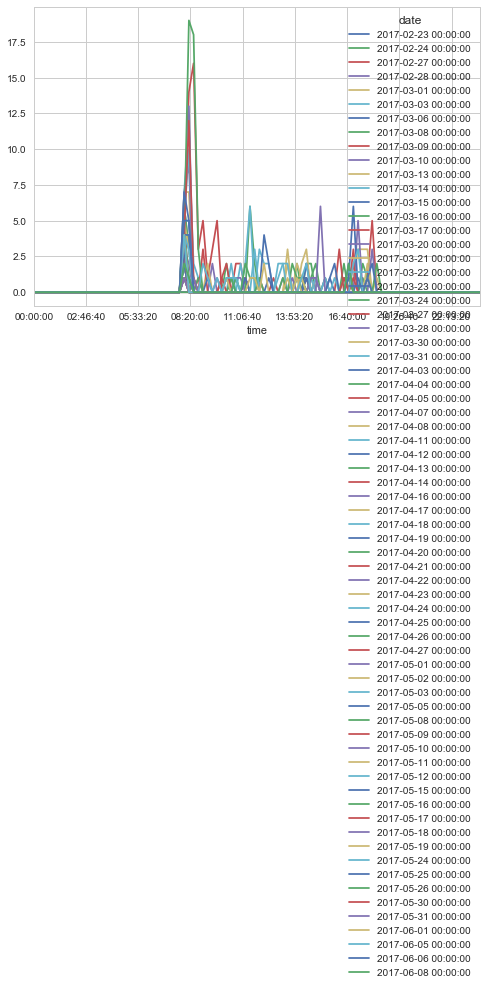

In [507]:
group_split_datetime.unstack('date')['avg wait time'].astype('timedelta64[m]').plot()

0.0


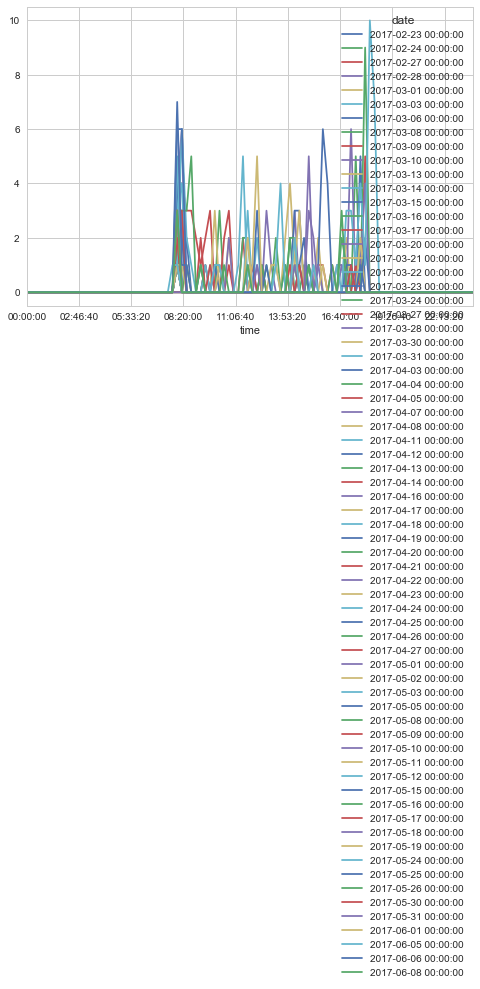

In [509]:
avg_abandonment_time = group_split_datetime['avg abandonment time'].astype('timedelta64[m]')
print(avg_abandonment_time.quantile(q=0.95))
avg_abandonment_time.unstack('date').plot()

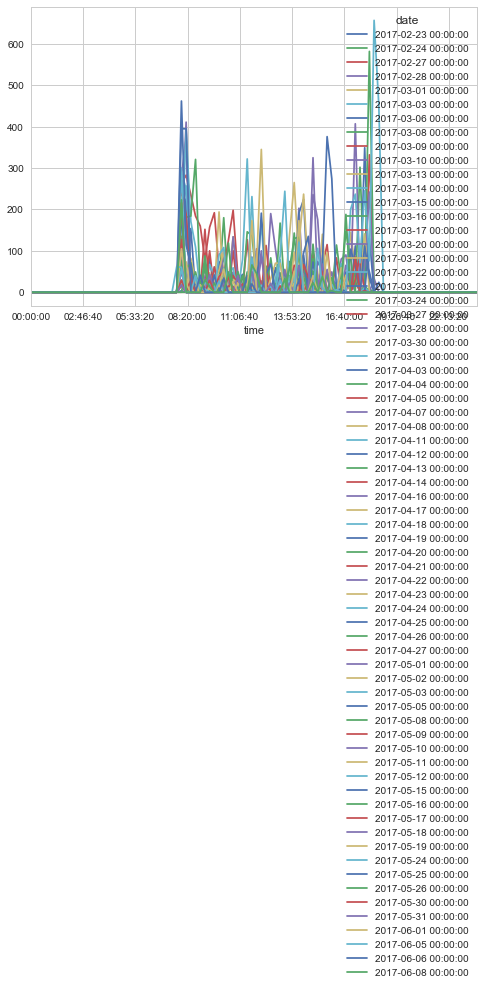

In [505]:
avg_abandonment_time.unstack('date').plot()